In [1]:
import os
path = os.path.abspath(os.getcwd())
print(path)
folder = os.path.split(path)[-1]
if folder == 'Subjects_Scripts':
    print('Subjects_Scripts')
    %run my_imports.py
elif folder == 'MySpaces':
    print('MySpaces')
    %run Subjects_Scripts/my_imports.py

C:\Users\bastien\Documents\Git\python_analysis_2\project\MySpaces\Subjects_Scripts
Subjects_Scripts


In [2]:
folderSubject = r'D:/DataSet/MySpaces/data/s03/'

In [3]:
folderName = os.path.join(folderSubject,'records','fif','agency')

raws_list,events = load_fif_from_folder(folderName,concatFile=False)

raws = mne.concatenate_raws(raws_list)
events = mne.find_events(raws, stim_channel='TRIGGER', shortest_event = 1)
montageFile = os.path.join(folderAnalysis,'locFile','montageANT64_inverse.txt')
layoutFile  = os.path.join(folderAnalysis,'locFile','antneuro_64ch.lay')
chan_dict_file = os.path.join(folderAnalysis,'locfile','chan_dict_64ANT.txt')

f = open(chan_dict_file,'r')
chan_dict = eval(f.read())
     
cfg= {'spatial_filter': 'CAR',
'montage_file':montageFile,
'layout_file':layoutFile}

scale = dict(mag=1e-12, grad=4e-11, eeg=100, eog=150, ecg=500,
     emg=1e3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1e3, chpi=1e-4, whitened=1e2)

print(raws.ch_names)

if 'AUX3' in raws.ch_names:
    print("1")
    resp_channel = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX3':'resp','M1':'emg','M2':'emg'}
elif 'AUX7' in raws.ch_names:
    print("2")
    resp_channel = "AUX7"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX7':'resp','M1':'emg','M2':'emg'}
elif 'AUX13' in raws.ch_names:
    print("3")
    resp_channel = "AUX13"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX13':'resp','M1':'emg','M2':'emg'}


raws.set_channel_types(mapping_channel_type)
raws = set_montage_from_file(raws,cfg,kind='topomap')

print('[Preprocessing] Preprocessed Data')

print('[Events Visualization] Checking events')
print(np.unique(events[:,2]))
print('[Events Visualization] Define dictionary for epoching')

[Load Data] Found 6 files
['TRIGGER', 'FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCZ', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ', 'AUX1', 'AUX13']
3
[Preprocessing] Preprocessed Data
[Events Visualization] Checking events
[ 10  20  30  40  60  70  99 110 112 113 114 115 116 117 118 119]
[Events Visualization] Define dictionary for epoching


In [4]:
idx_data_action = np.where(events[:,2] == 30)[0]
print(len(idx_data_action))
trial_remove = []
trialIdx = []
for i,idx_Start in enumerate(idx_data_action):
    if events[idx_Start + 1,2] == 40:
        pass
    else:
        trialIdx.append(i)
        trial_remove.append(idx_Start)
        events[idx_Start-1:idx_Start+2,2] = 0
        
print(trialIdx,trial_remove)

300
[16, 20, 124, 203, 275, 292] [98, 120, 751, 1227, 1663, 1765]


In [5]:
file = os.path.join(folderName,'pilot_logs.csv')
dataFrame = pd.read_csv(file,header=0)
dataFrame.head()

data_type_frame = dataFrame['trial_type']
data_type = data_type_frame.to_numpy()
data_type = (data_type != 'BMI').astype(int)+1

print(np.shape(data_type))
data_type = np.delete(data_type, trialIdx)
print(np.shape(data_type))

list_Type_trials = dict(cue=2,self=1)
print(list_Type_trials)

(300,)
(294,)
{'cue': 2, 'self': 1}


In [6]:
def min_max_normalization(data):
    return (data - np.nanmin(data))/(np.nanmax(data)-np.nanmin(data))
def zscore_normalization(data):
    return (data - np.nanmean(data))/np.nanstd(data)

In [7]:
agency_rate = dataFrame['agency'].to_numpy()
data_agency = np.zeros(np.shape(agency_rate))
nTrialPerBlock = 60
for i in range(0,len(agency_rate),nTrialPerBlock):
    data_agency_block = agency_rate[i:i+nTrialPerBlock]
    index_remove = np.where(data_agency_block == 0)[0]
    print(index_remove)
    data_agency_block = zscore_normalization(data_agency_block)
    data_agency_block[index_remove] = np.nan
    data_agency[i:i+nTrialPerBlock] = data_agency_block
print('Agency grade normalized an grade 0 set to Nan')

[]
[]
[ 0 28]
[]
[]
Agency grade normalized an grade 0 set to Nan


In [8]:
print(np.shape(data_agency))
data_agency = np.delete(data_agency, trialIdx)
print(np.shape(data_agency))

(300,)
(294,)


# Compute ERD/S

In [9]:
var = os.path.join(folderSubject,'power_events')
power_events = pickle.load(open( var, "rb")) 
print(power_events)

{'ST_ACTION_SELF': <EpochsTFR  |  time : [-4.000000, 2.000000], freq : [5.000000, 29.000000], epochs : 94, channels : 61, ~1.64 GB>, 'ST_ACTION_CUE': <EpochsTFR  |  time : [-4.000000, 2.000000], freq : [5.000000, 29.000000], epochs : 200, channels : 61, ~3.49 GB>}


In [10]:
self_based_trials = np.where(data_type == 1)[0]
cue_based_trials = np.where(data_type == 2)[0]
condition_dict_trials = {'ST_ACTION_SELF':self_based_trials,'ST_ACTION_CUE':cue_based_trials}
print(np.shape(condition_dict_trials['ST_ACTION_SELF']))
print(np.shape(condition_dict_trials['ST_ACTION_CUE']))

(89,)
(200,)


Mu
ST_ACTION_SELF
(89, 61)
[3 6 4 6 4 5 6 3 3 4 1 4 5 3 4 4 4 4 3 2 4 3 4 5 6 3 6 5 2 5 4 3 4 4 4 5 3
 1 2 4 4 5 5 3 3 5 3 5 5 5 5 5 4 5 5 4 3 4 4 5 4 3 4 2 4 3 3 4 5 5 5 4 4 4
 2 5 6 3 5 6 4 3 2 2 2 4 4 6 5]
0
1
2
3
4
5
ST_ACTION_CUE
(200, 61)
[4 4 3 4 5 5 4 4 3 4 4 4 4 5 5 4 5 4 4 2 2 2 2 2 4 4 5 4 5 5 4 3 3 5 2 4 3
 2 4 4 3 3 4 5 4 5 5 4 5 5 5 3 2 4 5 4 5 4 2 3 2 4 3 2 4 2 3 4 1 4 4 4 3 4
 4 4 4 3 4 4 3 1 3 3 5 5 3 4 3 4 3 3 3 2 4 4 5 4 3 3 3 5 1 3 3 2 1 3 3 4 5
 4 3 3 3 3 2 3 3 4 2 3 3 4 3 3 2 3 3 4 5 4 5 3 4 5 3 5 4 3 3 3 3 3 4 5 3 4
 5 3 5 3 4 5 4 2 3 4 5 3 3 4 2 3 4 4 3 2 4 4 4 5 4 4 4 5 4 3 4 3 4 4 2 4 4
 3 3 4 4 2 3 2 4 4 4 4 5 5 4 4]
0
1
2
3
4
5
Beta
ST_ACTION_SELF
(89, 61)
[3 6 4 6 4 5 6 3 3 4 1 4 5 3 4 4 4 4 3 2 4 3 4 5 6 3 6 5 2 5 4 3 4 4 4 5 3
 1 2 4 4 5 5 3 3 5 3 5 5 5 5 5 4 5 5 4 3 4 4 5 4 3 4 2 4 3 3 4 5 5 5 4 4 4
 2 5 6 3 5 6 4 3 2 2 2 4 4 6 5]
0
1
2
3
4
5
ST_ACTION_CUE
(200, 61)
[4 4 3 4 5 5 4 4 3 4 4 4 4 5 5 4 5 4 4 2 2 2 2 2 4 4 5 4 5 5 4 3 3 5 2 4 3
 2 4 4 3 3 4 5

<Figure size 864x288 with 0 Axes>

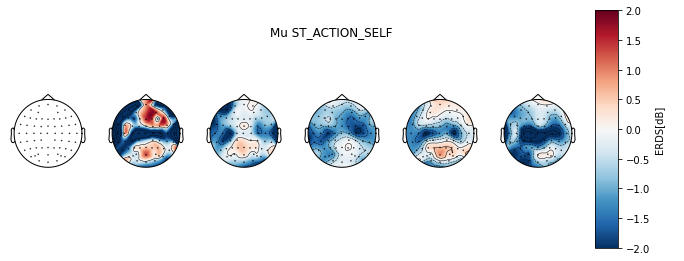

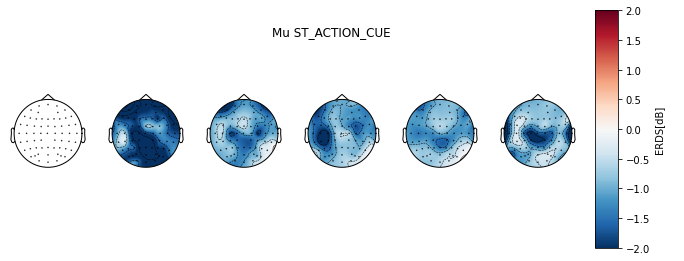

<Figure size 864x288 with 0 Axes>

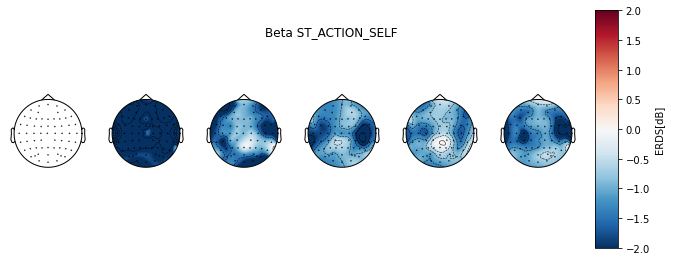

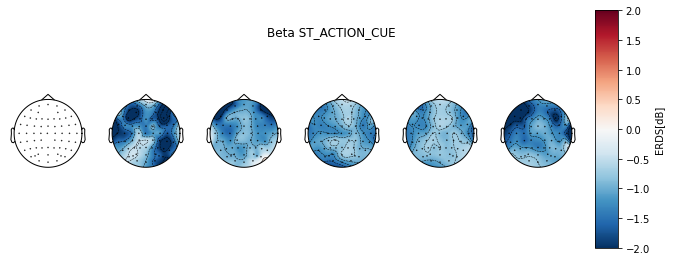

In [17]:
import seaborn as sns
import pandas as pd
from utils.utils_normalization import zscore_over_trials

iplot = 0
nbins = 6
bins = np.linspace(np.nanmin(data_agency),np.nanmax(data_agency), nbins)
df_events = dict()

iter_freqs = [
('Mu', 8, 12),
  ('Beta', 13, 29),
]
power_phase_av = dict()
nBand = len(iter_freqs)
scale = [-2,2]
my_cmap_r = reverse_colourmap(plt.cm.RdBu, name = 'RdBu')
my_cmap_r = center_cmap(my_cmap_r, scale[0], scale[1])  # zero maps to white

for band_name,fmin,fmax in iter_freqs:
    print(band_name)
    fig= plt.figure(figsize=(12, 4))
    for event_type,item in condition_dict_trials.items():
        print(event_type)
   
        iplot +=1
        # ERDS
        index_0 = np.where(power_events[event_type].times == 0)[0][0]
        data_mu =power_events[event_type].copy().crop(fmin=fmin,fmax=fmax)
        data_mu = np.nanmean(data_mu,axis=2)
        data_mu = np.squeeze(data_mu[:,:,index_0])
        print(np.shape(data_mu))
    
        # Trials agency
        data_agency_event = np.array(data_agency[item])
        ind = np.digitize(data_agency_event, bins)
        print(ind)
    
        agency_phase = np.zeros(np.shape(data_mu))
        power_phase_av_bins = []
    
        #Only for 1 sample
        for iBin in range(nbins):
            print(iBin)
            for iChan in range(61):
                A = np.array(ind==iBin).astype(float)
                A[A==0] = np.nan
                agency_phase[:,iChan] =  data_mu[:,iChan]*A
            mea = np.nanmean(np.squeeze(agency_phase),axis=0)
            power_phase_av_bins.append(mea)
            
        # Visualization
        fig, axes = plt.subplots(1, nbins+1,figsize=(12, 4))
        for i,ax in enumerate(axes[:-1]):
            mea = np.squeeze(power_phase_av_bins[i])
            ax = mne.viz.plot_topomap(mea,power_events[event_type].info,axes=ax, 
                            cmap=my_cmap_r,
                            vmin=scale[0], vmax=scale[1],show = False)
        axes[-1].axis('off')
        title = band_name + " "+ event_type
        power_phase_av.update({title:power_phase_av_bins})
        divider = make_axes_locatable(axes[-1])
        cax = divider.append_axes('left', size='40%')
        cb = fig.colorbar(axes[0].images[-1], cax=cax, pad=0.05)
        cb.ax.set_ylabel('ERDS[dB]')
        fig.suptitle(title,y=0.9)
        fig.show()        


# Saving Variable

In [ ]:
saving_var('power_events_agency_ERDS',folderSubject,power_phase_av)